# Image Classification
Classify Images and wether or not they have pizza or steak in the photo.  
This data will be sourced from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), particularly a subdivision of the images that only include  pizzas and steaks.  

## Pre-Built Image-recognition Models
Check out some pre-built models for image recognition:
- [ImageNet](https://www.image-net.org/): seems to be a giant well-built & well-used image-recognition model.
- [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)

In [31]:
import zipfile
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
import pandas as pd

## Download & Inspect Data

In [2]:
# Download zip file of pizza_steak images
fileName = 'pizza_steak.zip'
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile(fileName, "r")
zip_ref.extractall()
zip_ref.close()

--2024-06-14 20:14:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.187, 142.250.65.219, 142.250.81.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M  20.2MB/s    in 5.3s    

2024-06-14 20:14:49 (19.8 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



### Inspect The Data
The data is in a dir, `pizza_steak`.  
The dir has 2 subdirs, `test` and `train`.  
Each subdir has 2 subdirs, `pizza` and `steak`.  
Each `pizza` and `steak` dir has images included.

In [3]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [4]:
# 
# SUMMARY OF DATA
# 

parentDir = 'pizza_steak'
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk(parentDir):
  if(len(filenames) > 0):
      print(f"    {len(filenames)} images in '{dirpath}'.")
  else:
      print(f"DIR: '{dirpath}' has {len(dirnames)} dirs")

DIR: 'pizza_steak' has 2 dirs
DIR: 'pizza_steak/train' has 2 dirs
    750 images in 'pizza_steak/train/pizza'.
    750 images in 'pizza_steak/train/steak'.
DIR: 'pizza_steak/test' has 2 dirs
    250 images in 'pizza_steak/test/pizza'.
    250 images in 'pizza_steak/test/steak'.


In [5]:
# 
# GET CLASS NAMES
# 
cleanPath = f'{parentDir}/train/'
trainingPath = pathlib.Path(cleanPath)
classNames = sorted([item.name for item in trainingPath.glob('*')])
npClassNames = np.array(classNames) # created a list of class_names from the subdirectories
print(npClassNames)

['pizza' 'steak']


### Preview Some Images

In [6]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


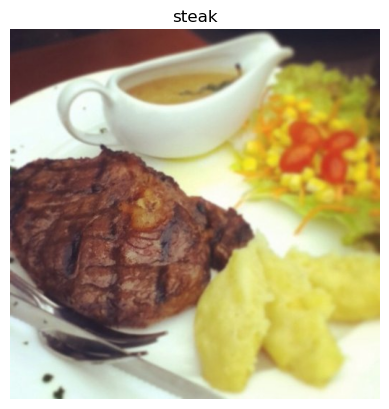

In [7]:
img = view_random_image(target_dir=cleanPath,
                        target_class="steak")

In [8]:
img

array([[[ 39,  31,  44],
        [ 39,  31,  44],
        [ 40,  32,  45],
        ...,
        [ 30,  24,  38],
        [ 30,  24,  38],
        [ 31,  25,  39]],

       [[ 39,  31,  44],
        [ 39,  31,  44],
        [ 40,  32,  45],
        ...,
        [ 30,  24,  38],
        [ 31,  25,  39],
        [ 31,  25,  39]],

       [[ 39,  31,  44],
        [ 39,  31,  44],
        [ 39,  31,  44],
        ...,
        [ 31,  25,  39],
        [ 31,  25,  39],
        [ 31,  25,  39]],

       ...,

       [[232, 251, 249],
        [232, 251, 249],
        [232, 251, 249],
        ...,
        [245, 254, 237],
        [245, 254, 237],
        [245, 254, 237]],

       [[232, 251, 249],
        [232, 251, 249],
        [232, 251, 249],
        ...,
        [245, 254, 237],
        [245, 254, 237],
        [245, 254, 237]],

       [[231, 250, 248],
        [231, 250, 248],
        [231, 250, 248],
        ...,
        [245, 254, 237],
        [245, 254, 237],
        [245, 254, 237]]

In [9]:
print(f'img shape: {img.shape}')

img shape: (512, 512, 3)


### Key Points
- the data is a bunch of images
- the images are split into directories: test & train, then by classification (2 classifications)
- the shape of the images are 512x512 with a 3-color representation per pixel (probably rgb)
  - it has become common to reshape the images to fit a `224x224` size
  - the rgb values
    - fit between 0-255, where 0 is "black" and 255 is "white"
    - 1st digit is `red`
    - 2nd digit is `green`
    - 3rd digit is `blue`

## Build A Model: CNN
### About Convolutional Neural Networks

Parts of a CNN:
- input (images)
- LAYERS & related details
  - **input layer**: batch_size, img dimensions, classification mode
  - **convolution layer**: figures out "the most important" patterns to learn, `Conv2D`
  - **hidden activation**: add "non-linearity" to learned features, most typically `relu`
  - **pooling layer**: reduces diemsions of learned features, `AvgPool2d`, `MaxPool2D`
  - **"fully connected" layer**: , a "last step" aggregating / refining the convolution layers `Dense`
  - **output layer**: fits to the desired number of "classes" to learn
  - **output activation** add non-linearity to the output layer, `sigmoid` or `softmax`

A typical CNN structure:
```Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output```

### Prep the model Data

In [23]:
# Set the seed
tf.random.set_seed(42)
imgW = 224
imgH = 224
maxScaleNumber = 255

# 
# batch_size: limits amount of data in memory at once (in batches!)
# 32 has become a regular starting place in the machine-learning world
# 
imagesInABatch = 32

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
# rescaling normalizes 0-255 values to 0-1
train_datagen = ImageDataGenerator(rescale=1./maxScaleNumber)
valid_datagen = ImageDataGenerator(rescale=1./maxScaleNumber)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# 
# BATCH the data
# 
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=imagesInABatch, # number of images to process at a time 
                                               target_size=(imgW, imgH), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=imagesInABatch,
                                               target_size=(imgW, imgH),
                                               class_mode="binary",
                                               seed=42)
# for later modeling
test_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=imagesInABatch,
                                               target_size=(imgW, imgH),
                                               class_mode="binary",
                                               seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [11]:
print(f'how many items in train_data? {len(train_data)}')
print(f'how many items in the firt element of train_data? {len(train_data[0])}')

how many items in train_data? 47
how many items in the firt element of train_data? 2


### Inspect some training data

In [12]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
print(f'images:{len(images)}, labels:{len(labels)}')

# NOTICE LABELS:
# 0 or 1
print('labels:')
labels

images:32, labels:32
labels:


array([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

### Build the Model

In [13]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
imageW = 224
imageH = 224
imageColorCount = 3
convoFilterCount = 10
convoKernelCount = 3
maxPoolSize = 2

m1 = tf.keras.models.Sequential([
  Conv2D(filters=convoFilterCount, 
                         kernel_size=convoKernelCount, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(imageW, imageH, imageColorCount)), # first layer specifies input shape (height, width, colour channels)
  Conv2D(convoFilterCount, convoKernelCount, activation="relu"),
  MaxPool2D(pool_size=maxPoolSize, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  Conv2D(convoFilterCount, convoKernelCount, activation="relu"),
  Conv2D(convoFilterCount, convoKernelCount, activation="relu"), # activation='relu' == Activations(tf.nn.relu)
  MaxPool2D(maxPoolSize),
  Flatten(),
  Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
m1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
m1History = m1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 246s 5s/step - loss: 0.5800 - accuracy: 0.6887 - val_loss: 0.4186 - val_accuracy: 0.8280
Epoch 2/5
47/47 [==============================] - 241s 5s/step - loss: 0.4486 - accuracy: 0.7953 - val_loss: 0.3671 - val_accuracy: 0.8600
Epoch 3/5
47/47 [==============================] - 240s 5s/step - loss: 0.3957 - accuracy: 0.8213 - val_loss: 0.3784 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 240s 5s/step - loss: 0.3453 - accuracy: 0.8567 - val_loss: 0.3041 - val_accuracy: 0.8620
Epoch 5/5
47/47 [==============================] - 239s 5s/step - loss: 0.2619 - accuracy: 0.8900 - val_loss: 0.3799 - val_accuracy: 0.8480


## Inspect The Model Results

In [14]:
# Check out model_3 architecture
m1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

## Build A Model II: Binary Classification
Binary classification models are significantly "simpler" than CNNs.  
Let's see how a Binary CLassification model 

In [27]:
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
m2 = tf.keras.Sequential([
  Flatten(input_shape=(imgW, imgH, 3)), # dense layers expect a 1-dimensional vector as input
  Dense(4, activation='relu'),
  Dense(4, activation='relu'),
  Dense(1, activation='sigmoid')
])

# Compile the model
m2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
m2History = m2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 20s 362ms/step - loss: 0.7690 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 16s 349ms/step - loss: 0.6932 - accuracy: 0.4720 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 16s 350ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 17s 353ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 16s 349ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


### Inspect the Model

In [28]:
m1.summary()
m2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

## Build A Model III: Binary Adjusted

In [17]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
m3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(imgW, imgH, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
m3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
m3History = m3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

47/47 [==============================] - 54s 1s/step - loss: 0.8266 - accuracy: 0.7380 - val_loss: 0.4541 - val_accuracy: 0.7740
Epoch 3/5
47/47 [==============================] - 53s 1s/step - loss: 0.6977 - accuracy: 0.7300 - val_loss: 0.4887 - val_accuracy: 0.7600
Epoch 4/5
47/47 [==============================] - 52s 1s/step - loss: 0.4761 - accuracy: 0.7933 - val_loss: 0.5290 - val_accuracy: 0.7400
Epoch 5/5
47/47 [==============================] - 53s 1s/step - loss: 0.5867 - accuracy: 0.7553 - val_loss: 0.9273 - val_accuracy: 0.6900


### Inspect The Model

In [29]:
m2.summary()
m3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 150528)            0         
                                                                 
 dense_10 (Dense)            (None, 4)                 602116    
                                                                 
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
 dense_12 (Dense)            (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

Interestingly
- the binary classification models have WAY MORE PARAMETERS than the CNN

## Build A Model: CNN "Baseline"
Setup a "simple" model to start with:
- `2D` layers refer to the data have 2 "dimensions": height + width (color is a data attribute of each height/width pixel)
- `filters`: the number of "feature extractions" as the convolution deals with the image
- `kernel_size` is describes the shape of a grid of pixes. The smaller, the more "fine-grained" the feature detection will be
- [`stride`](https://deepai.org/machine-learning-glossary-and-terms/stride): describes the movement of a kernel across the image (in pixels-per-stride)
- `padding`: to cut-off or not pixels when the `filter` may not cover pixels. a 224w image with a 3x3 filter will leave a few pixels un"filtered", as a 3px-wide filter will cover 222 pixels by moving 74x
- `features` in cnn are "significant" parts of images that the CNN has figured out

### Build The Model

In [24]:
m4 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

### Compile The Model

In [25]:
# Compile the model
m4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

### Fit The Model

In [26]:
# Fit the model
m4History = m4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 298s 6s/step - loss: 2.2443 - accuracy: 0.6373 - val_loss: 0.4372 - val_accuracy: 0.8060
Epoch 2/5
47/47 [==============================] - 315s 7s/step - loss: 0.4729 - accuracy: 0.7860 - val_loss: 0.3811 - val_accuracy: 0.8380
Epoch 3/5
47/47 [==============================] - 315s 7s/step - loss: 0.2922 - accuracy: 0.8960 - val_loss: 0.3718 - val_accuracy: 0.8500
Epoch 4/5
47/47 [==============================] - 294s 6s/step - loss: 0.1245 - accuracy: 0.9653 - val_loss: 0.3690 - val_accuracy: 0.8360
Epoch 5/5
47/47 [==============================] - 314s 7s/step - loss: 0.0529 - accuracy: 0.9920 - val_loss: 0.4687 - val_accuracy: 0.8120


### Inspect The Model

In [30]:
m2.summary()
m3.summary()
m4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 150528)            0         
                                                                 
 dense_10 (Dense)            (None, 4)                 602116    
                                                                 
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
 dense_12 (Dense)            (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

### Visualze CNN Model Stats

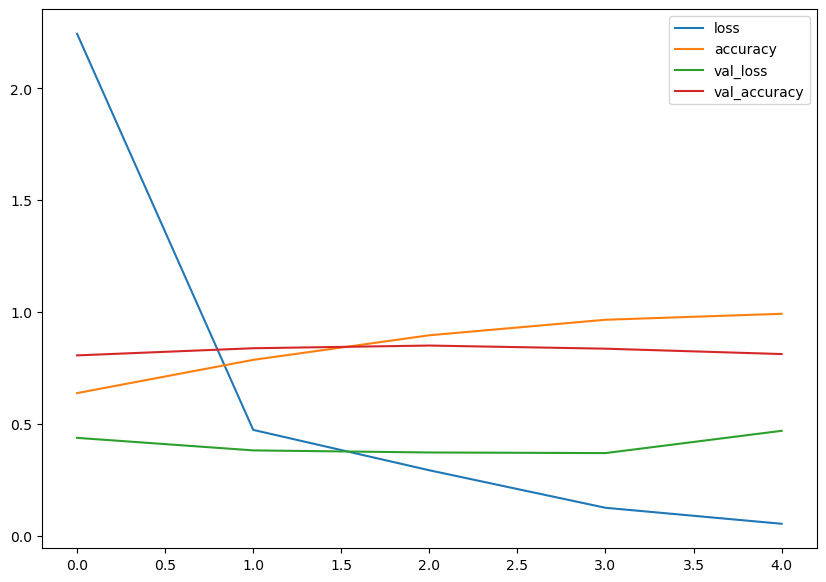

In [32]:
pd.DataFrame(m4History.history).plot(figsize=(10, 7));

In [33]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

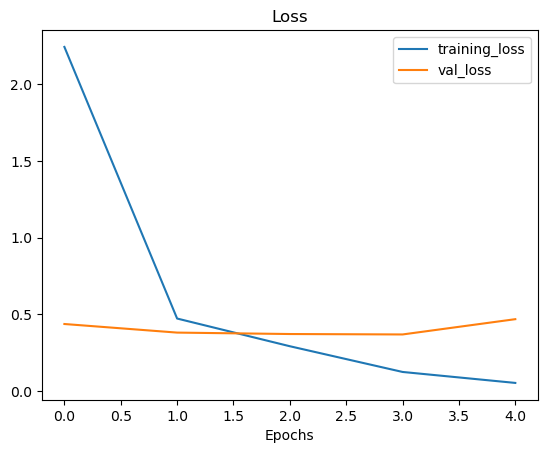

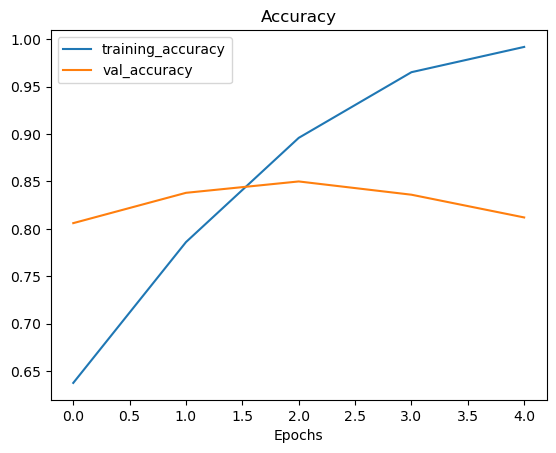

In [34]:
# Check out the loss curves of model_4
plot_loss_curves(m4History)

### Beware Overfitting
Above, the `val_loss` goes UP after the 3rd epoch. INCREASING loss means over-fitting. Over-fitting is when the model gets excellent at predicting based on the data it was trained & tested with, BUT will loose the ability to predict NEW input as well. 

## Adjust The Model
- build
- overfit
- reduce overfitting (by a few approaches):
  - increase convolutional layers
  - increase convolutional filters
  - add dense layer to the output of the flattened layer